# Baseline model for batch monitoring example

In [47]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric, ColumnCorrelationsMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
files = [('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data'), ('green_tripdata_2024-03.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2022-02.parquet:   1%|          | 10609/1428262 [00:00<00:13, 106079.73it/s, save to ./data/green_tripdata_2022-02.parquet]

green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:12<00:00, 112782.49it/s, save to ./data/green_tripdata_2024-03.parquet]


In [3]:
jan_data = pd.read_parquet('data/green_tripdata_2022-01.parquet')

In [4]:
march_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')
march_data.shape

(57457, 20)

In [5]:
jan_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,62495.000000,62495,62495,56200.000000,62495.000000,62495.000000,56200.000000,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000,56200.000000,56200.000000
mean,1.849508,2022-01-16 14:18:36.026354,2022-01-16 14:37:37.189551,1.198719,97.615041,135.969902,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,1.403594,1.040925,0.706628
min,1.000000,2009-01-01 00:34:01,2009-01-01 17:05:20,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000
25%,2.000000,2022-01-08 23:41:50,2022-01-08 23:55:28.500000,1.000000,55.000000,74.000000,1.000000,1.080000,7.000000,0.00000,0.500000,0.000000,0.000000,0.300000,9.360000,1.000000,1.000000,0.000000
50%,2.000000,2022-01-16 15:59:42,2022-01-16 16:17:00,1.000000,75.000000,137.000000,1.000000,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,1.000000,1.000000,0.000000
75%,2.000000,2022-01-24 09:16:50,2022-01-24 09:37:28,1.000000,130.000000,215.000000,1.000000,3.500000,17.000000,0.50000,0.500000,2.610000,0.000000,0.300000,21.050000,2.000000,1.000000,2.750000
max,2.000000,2022-01-31 23:57:37,2022-02-01 21:01:54,5.000000,265.000000,265.000000,8.000000,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,5.000000,2.000000,2.750000
std,0.357556,NaN,NaN,0.862313,62.987311,77.590956,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,0.516316,0.198119,1.201632


In [6]:
# create target
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [7]:
# filter out outliers
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]

<Axes: >

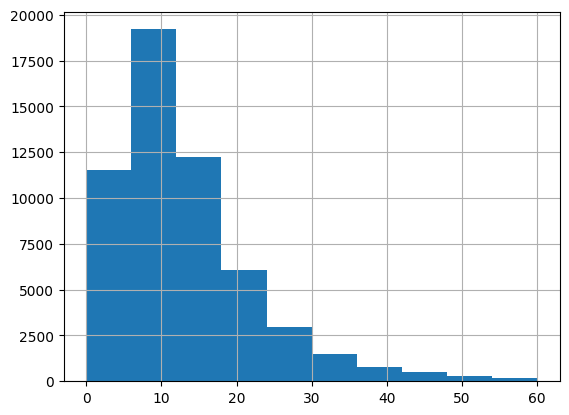

In [8]:
jan_data.duration_min.hist()

In [9]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [10]:
jan_data.shape

(55211, 21)

In [11]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]

In [12]:
model = LinearRegression()

In [13]:
model.fit(train_data[num_features + cat_features], train_data[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [15]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [16]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.804665373785062
4.142064073688447


# Dump model and reference data

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [18]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [19]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [20]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric()
]
)

In [21]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [22]:
#report.show(mode='inline')

In [23]:
result = report.as_dict()

In [25]:
#prediction drift
result['metrics'][0]['result']['drift_score']

np.float64(0.03049316466166379)

In [26]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [27]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

np.float64(0.045454545454545456)

# Evidently Dashboard

In [28]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [86]:
ws = Workspace("workspace")

In [114]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "March 2024"
project.save()

Project(id=UUID('01979ab1-dee6-7001-8627-0f4c3811c8cc'), name='NYC Taxi Data Quality Project', description='March 2024', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, org_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2025, 6, 23, 2, 50, 37, 670651), version='1')

In [115]:
march_data['lpep_pickup_datetime'].describe()

count                         57457
mean     2024-03-16 04:02:52.405399
min             2008-12-31 23:02:24
25%             2024-03-08 13:53:56
50%             2024-03-15 22:49:01
75%             2024-03-23 20:11:25
max             2024-04-01 00:01:45
Name: lpep_pickup_datetime, dtype: object

# March Report Data

In [116]:
def build_daily_report(i, df):
    begin = datetime.datetime(2024, 3, 1, 0, 0)
    daily_report = Report(metrics=[ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)],
                          timestamp=begin + datetime.timedelta(i))
    print(f"Running Report for {(begin + datetime.timedelta(i))} to {(begin + datetime.timedelta(i+1))}")
    daily_report.run(reference_data=None,
                     current_data=df[(df.lpep_pickup_datetime >= (begin + datetime.timedelta(i))) & 
                                  (df.lpep_pickup_datetime < (begin + datetime.timedelta(i + 1)))],
                  column_mapping=column_mapping)
    return daily_report

In [117]:
tmp = []
for i in range(0,31):
    report = build_daily_report(i, march_data)
    ws.add_report(project.id, report)
    tmp.append(report.as_dataframe())

Running Report for 2024-03-01 00:00:00 to 2024-03-02 00:00:00
Running Report for 2024-03-02 00:00:00 to 2024-03-03 00:00:00
Running Report for 2024-03-03 00:00:00 to 2024-03-04 00:00:00
Running Report for 2024-03-04 00:00:00 to 2024-03-05 00:00:00
Running Report for 2024-03-05 00:00:00 to 2024-03-06 00:00:00
Running Report for 2024-03-06 00:00:00 to 2024-03-07 00:00:00
Running Report for 2024-03-07 00:00:00 to 2024-03-08 00:00:00
Running Report for 2024-03-08 00:00:00 to 2024-03-09 00:00:00
Running Report for 2024-03-09 00:00:00 to 2024-03-10 00:00:00
Running Report for 2024-03-10 00:00:00 to 2024-03-11 00:00:00
Running Report for 2024-03-11 00:00:00 to 2024-03-12 00:00:00
Running Report for 2024-03-12 00:00:00 to 2024-03-13 00:00:00
Running Report for 2024-03-13 00:00:00 to 2024-03-14 00:00:00
Running Report for 2024-03-14 00:00:00 to 2024-03-15 00:00:00
Running Report for 2024-03-15 00:00:00 to 2024-03-16 00:00:00
Running Report for 2024-03-16 00:00:00 to 2024-03-17 00:00:00
Running 

In [118]:
pd.concat(tmp)['current_value'].max()

np.float64(14.2)

In [121]:
#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi data dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Quantiles for Fare Amount",
        values=[
            PanelValue(
                metric_id="ColumnQuantileMetric",
                field_path="current", # Does not work to show in dashboard. Needs check
                legend="median"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('01979ab1-dee6-7001-8627-0f4c3811c8cc'), name='NYC Taxi Data Quality Project', description='March 2024', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('01979ab2-0e08-7e6f-ba3d-c8401ca0bea4'), title='NYC taxi data dashboard', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text=None), DashboardPanelPlot(type='evidently:dashboard_panel:DashboardPanelPlot', id=UUID('01979ab2-0e09-7e35-90b5-dd758409acfe'), title='Quantiles for Fare Amount', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.value', metric_id='ColumnQuantileMetric', metric_fingerprint=None, metric_args={}, legend='median')], plot_type=<PlotType.LINE: 'line'>), DashboardPanelCounter(type='evidently:d

# Dashboard Ouput

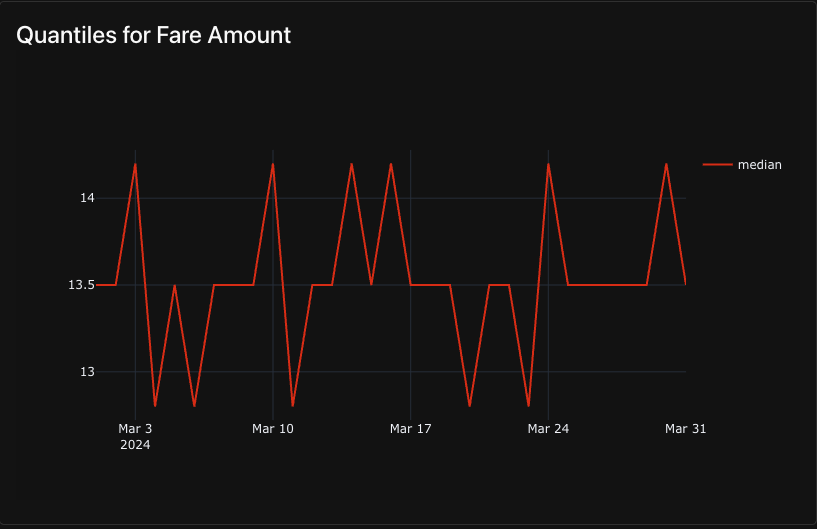

In [134]:
report.as_dict()['metrics'][0]['result']['current']

{'value': np.float64(13.5)}